# MNIST Classification

In [1]:
import sys
from microtorch import nn, Tensor
from microtorch.optim import Adam, Optimizer
from microtorch.losses import CrossEntropyLoss
from microtorch.utils.trainer import Trainer
from microtorch.utils.loss_dict import LossDict
from microtorch.data.data import default_collate_fn, Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets.mnist import MNIST


from pathlib import Path

## Dataset and DataLoader

In [2]:
mnist = MNIST(root='./data', train=True, download=True, transform=None)

In [3]:
X_train = mnist.data.float().numpy() / 255
y_train = mnist.targets.numpy()

In the next step we define a PyTorch-like Dataset that inherits from the `microtorch` Dataset base class.

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return Tensor(self.X[idx]), Tensor(self.y[idx])

In [5]:
ds = MNISTDataset(X_train, y_train)

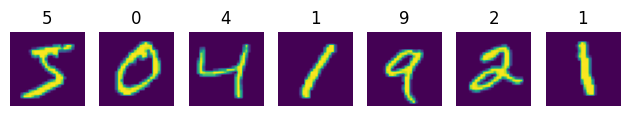

In [6]:
for i in range(7):
    X, y = ds[i]
    plt.subplot(1, 7, i+1)
    plt.imshow(X.data)
    plt.title(y.data)
    plt.axis('off')

plt.tight_layout()

Since we need to pass the data to the neural network in a batched format, we wrap our dataset with a DataLoader, 
which is responible to shuffle the data and prepare it to batched Tensors: 

In [7]:
dl = DataLoader(ds, batch_size=128, shuffle=True)

In [8]:
x, y = next(iter(dl))
print(x.shape, y.shape)

(128, 28, 28) (128,)


## Model

In this step, we create our model. This can be done by using the same API as in PyTorch.

In [9]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28**2, 512),
    nn.LeakyReLU(),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10)
)

## Training

In the next step, we create a Trainer object, that provides an API, which abstracts some of the optimization code.
Thus, we only need to define the functionality for one training step.

During training, we are also interested in the accuracy metric, which we define in the following.

After defining the aforementioned classes, we instantiate a MNISTTrainer object by passing the model to be trained,
the CrossEntropyLoss as training objective, Adam as an optimizer, and at least the Accuracy metric.

In [10]:
class MNISTTrainer(Trainer):
    def train_step(self, batch) -> LossDict:
        X, y = batch
        pred = self.model(X)
        loss = self.criterion(pred, y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return LossDict(loss=loss.data, **self.compute_metrics(pred, y))

class Accuracy(nn.Module):
    def __call__(self, logits: Tensor, targets: Tensor) -> Tensor:
        return Tensor(np.mean(logits.data.argmax(axis=-1) == targets.data))

trainer = MNISTTrainer(
    model=model,
    criterion=CrossEntropyLoss(),
    optimizer=Adam(model.params(), lr=0.001),
    metrics={
        'accuracy': Accuracy()
    }
)

Let's see if everything works. In the following, we train our model for one epoch.

In [11]:
trainer.fit(epochs=1, dataloader=dl)

Epoch 1: 469it [00:18, 25.65it/s, accuracy=0.9282, loss=0.2389]                 


## Test

During training our model reached an average accuracy of up to 93%.

In this example, we will make some test predictions on the training dataset:

In [14]:
X, y = next(iter(dl))
pred = model(X).data.argmax(axis=-1)

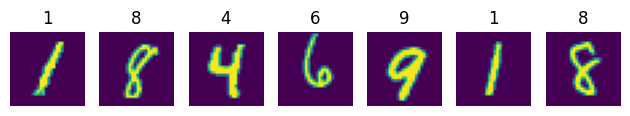

In [15]:
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(X[i].data)
    plt.title(pred[i])
    plt.axis('off')

plt.tight_layout()